In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from skimage import io, color
import pandas as pd
import os
from tqdm.notebook import tqdm

In [ ]:
# Takes inputs with dims = (N, C, *)
# Gives outputs with dimes = (N, C, *)
class LocalResponseNormalization(nn.Module):
    def __init__(self, neighbourhood_length, normalisation_const_alpha, contrast_const_beta, noise_k):
        super(LocalResponseNormalization, self).__init__()
        self.nbd_len = neighbourhood_length
        self.alpha = normalisation_const_alpha
        self.beta = contrast_const_beta
        self.k = noise_k

    # The following is exactly what pytorch does under the hood as well. I only replicated it for my understanding :)
    def forward(self, x):
        # Lets validate if x is atleast 3 dimensional
        dim = x.dim()
        if dim < 3:
            raise ValueError("Expected tensor of atleast 3 dimensions, found only {}".format(dim))
        denom = x.pow(2).unsqueeze(1)
        if dim == 3:
            denom = F.pad(denom, (0, 0, self.nbd_len // 2, (self.nbd_len - 1) // 2))
            denom = F.avg_pool2d(denom, (self.nbd_len, 1), stride=1)
            denom = denom.squeeze(1)
        else:
            sizes = x.size()
            # The last two dimensions make up a single channel. The third dimension decides the number of channels
            # across which we will apply local response normalization.
            denom = denom.view(sizes[0], 1, sizes[1], sizes[2], -1)
            # The point is to pad in front and back of the channels across which we'll apply normalization
            denom = F.pad(denom, (0, 0, 0, 0, self.nbd_len // 2, (self.nbd_len - 1) // 2))
            denom = F.avg_pool3d(denom, (self.nbd_len, 1, 1), stride=1)
            denom = denom.squeeze(1).view(sizes)
        denom = denom.mul(self.alpha).add(self.k).pow(self.beta)
        return x.div(denom)

In [ ]:
# Expects input tensor to be of dimensions (batch_size, 3, 224, 224)
class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=256 * 6 * 6, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=10)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        # This layer helps us avoid calculating output map size when feeding into a linear layer in PyTorch.
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.norm = LocalResponseNormalization(neighbourhood_length=5, normalisation_const_alpha=1e-4, contrast_const_beta=0.75, noise_k=1.0)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.max_pool(self.norm(F.relu(self.conv1(x))))
        x = self.max_pool(self.norm(F.relu(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.adaptive_pool(self.norm(F.relu(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
class SceneDataset(Dataset):
    def __init__(self, annotations_csv, root_dir, transform=None):
        self.annotations = pd.read_csv(annotations_csv)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        return [image, label]

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    # Don't forget to toggle to eval mode!
    model.eval()

    with torch.no_grad():
        for data, targets in tqdm(loader):
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print("Correct: {}, Total: {}, Accuracy: {}".format(num_correct, num_samples, int(num_correct) / int(num_samples)))
    # Don't forget to toggle back to model.train() since you're done with evaluation
    model.train()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/KIST Hackathon 2023/Phase II workshop/Day 1/files and datasets/files

/content/drive/My Drive/KIST Hackathon 2023/Phase II workshop/Day 1/files and datasets/files


In [ ]:
if __name__ == '__main__':

    LEARNING_RATE = 0.0001
    # You could try playing around with the batch size(say 16) and learning rate(say 0.001) for faster convergence.
    BATCH_SIZE = 8
    EPOCHS = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"

    transform_img = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    data = SceneDataset(annotations_csv="train-scene classification/train.csv",
                          root_dir="train-scene classification/train",
                          transform = transform_img)
    print(len(data))
    train_data, test_data = torch.utils.data.random_split(data, [65, 9])
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

    alexnet = Alexnet()
    alexnet.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(alexnet.parameters(), lr=LEARNING_RATE)

    data, targets = next(iter(train_loader))
    for epoch in tqdm(range(EPOCHS)):
        losses = []
        with tqdm(total=len(train_loader)) as pbar:
            for batch_idx, (data, targets) in enumerate(train_loader):
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = alexnet(data)
                loss = criterion(scores, targets)
                losses.append(loss)

                # backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
#                 print(loss.item())
                pbar.update(1)
        print("Cost at epoch {} is {}".format(epoch, sum(losses) / len(losses)))
        check_accuracy(train_loader, alexnet)
        check_accuracy(test_loader, alexnet)


74


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 0 is 2.16434645652771


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 1 is 1.852213978767395


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 12, Total: 65, Accuracy: 0.18461538461538463


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 2, Total: 9, Accuracy: 0.2222222222222222


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 2 is 1.7962262630462646


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 3 is 1.7451280355453491


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 13, Total: 65, Accuracy: 0.2


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 2, Total: 9, Accuracy: 0.2222222222222222


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 4 is 1.8231004476547241


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 5 is 1.7108700275421143


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 6 is 1.7383476495742798


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 7 is 1.7131898403167725


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 8 is 1.6628814935684204


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


  0%|          | 0/9 [00:00<?, ?it/s]

Cost at epoch 9 is 1.7571274042129517


  0%|          | 0/9 [00:00<?, ?it/s]

Correct: 20, Total: 65, Accuracy: 0.3076923076923077


  0%|          | 0/2 [00:00<?, ?it/s]

Correct: 1, Total: 9, Accuracy: 0.1111111111111111


In [ ]:
import matplotlib.pyplot as plt

def show_image_and_prediction(img_path):
    idx2label = {0: "Buildings", 1: "Forests", 2: "Mountains", 3: "Glacier", 4: "Sea", 5: "Street"}
    img = io.imread(img_path)
    transformed_img = transform_img(img)
    out = alexnet(transformed_img.unsqueeze(0).to(device=device))
    _, pred = out.max(1)
    plt.imshow(img)
    plt.show()
    print("Alexnet thinks this scence contains: {}".format(idx2label[pred.item()]))

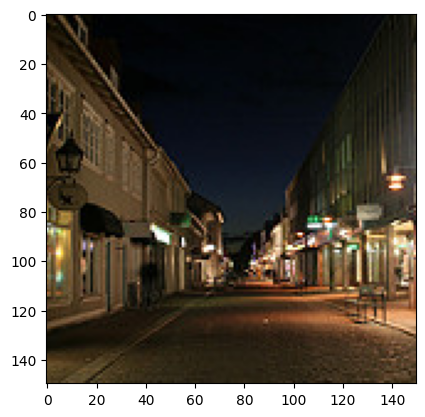

Alexnet thinks this scence contains: Street


In [ ]:
show_image_and_prediction("train-scene classification/train/50.jpg")

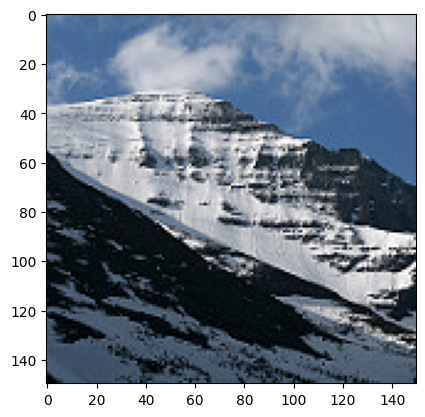

Alexnet thinks this scence contains: Street


In [ ]:
show_image_and_prediction("train-scene classification/train/30.jpg")

Yolo Model:

In [ ]:
!pip install ultralytics==8.0.20

In [ ]:
from IPython import display
display.clear_output()

from ultralytics import YOLO
from IPython.display import display, Image

In [ ]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='images2.jpg' save=true

2023-09-12 14:09:03.585009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 14:09:04.751814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/drive/MyDrive/KIST Hackathon 2023/Phase II workshop/Day 1/files and datasets/files/images2.jpg: 448x640 2 zebras, 115.1ms
Speed: 1.3ms pre-process, 115.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


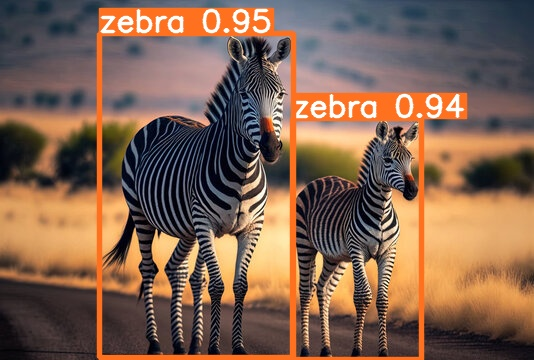

In [ ]:
Image(filename='runs/detect/predict3/images2.jpg', height=500)

Yolo live detection

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15750, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 15750 (delta 103), reused 155 (delta 86), pack-reused 15537
Receiving objects: 100% (15750/15750), 14.62 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (10536/10536), done.
Updating files: 100% (2063/2063), done.


In [ ]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/drive/MyDrive/KIST Hackathon 2023/Phase II workshop/Day 1/files and datasets/files/darknet


In [ ]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1444:14: warning: unus

In [ ]:
# get bthe scaled yolov4 weights file that is pre-trained to detect 80 classes (objects) from shared google drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2023-09-12 14:22:03--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.142.102, 74.125.142.101, 74.125.142.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ilu0v3i7v7on09ejrqa2ch7seounilc/1694528475000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=fdaaab0f-ee4f-4ac9-9087-a5f5563ff297 [following]
--2023-09-12 14:22:04--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ilu0v3i7v7on09ejrqa2ch7seounilc/1694528475000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=fdaaab0f-ee4f-4ac9-9087-a5f5563ff297
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 74.125.197.132, 

In [ ]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

OSError: ignored

In [ ]:
# run test on person.jpg image that comes with repository
image = cv2.imread("images1.jpeg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes